# Sklearn v1.1 and Feature Importance

Kris Barbier

## Imports

In [1]:
#Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Machine learning imports
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
#Set pandas config to show more columns
pd.set_option('display.max_columns',50)
#Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)

## Custom Functions

In [15]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [16]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [17]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

## Load and Inspect Data

In [2]:
#Load in data
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSnWFRczgXa0AyKkbioX5Roq60X7GTAFilKtpFuAmyGi9uPMwdb51Jo-cpupDyjhT0EVqcNRJPINZ5b/pub?output=csv'
df = pd.read_csv(url)

In [3]:
#Preview first 5 rows
df.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,6,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,4,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,5,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [4]:
#Preview info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   fueltype          205 non-null    object 
 2   aspiration        205 non-null    object 
 3   doornumber        205 non-null    object 
 4   carbody           205 non-null    object 
 5   drivewheel        205 non-null    object 
 6   enginelocation    205 non-null    object 
 7   wheelbase         205 non-null    float64
 8   carlength         205 non-null    float64
 9   carwidth          205 non-null    float64
 10  carheight         205 non-null    float64
 11  curbweight        205 non-null    int64  
 12  enginetype        205 non-null    object 
 13  cylindernumber    205 non-null    int64  
 14  enginesize        205 non-null    int64  
 15  fuelsystem        205 non-null    object 
 16  boreratio         205 non-null    float64
 1

## Preprocessing

In [5]:
#Define X and y
y = df['price']
X = df.drop(columns = 'price')

In [6]:
#Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED)
X_train.head(2)

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
90,1,diesel,std,two,sedan,fwd,front,94.5,165.3,63.8,54.5,2017,ohc,4,103,idi,2.99,3.47,21.9,55,4800,45,50
173,-1,gas,std,four,sedan,fwd,front,102.4,175.6,66.5,54.9,2326,ohc,4,122,mpfi,3.31,3.54,8.7,92,4200,29,34


In [8]:
#Make categorical selector and verify it works
cat_sel = make_column_selector(dtype_include = 'object')
cat_sel(X_train)

['fueltype',
 'aspiration',
 'doornumber',
 'carbody',
 'drivewheel',
 'enginelocation',
 'enginetype',
 'fuelsystem']

In [9]:
#Make numeric selector and verify it works
num_sel = make_column_selector(dtype_include = 'number')
num_sel(X_train)

['symboling',
 'wheelbase',
 'carlength',
 'carwidth',
 'carheight',
 'curbweight',
 'cylindernumber',
 'enginesize',
 'boreratio',
 'stroke',
 'compressionratio',
 'horsepower',
 'peakrpm',
 'citympg',
 'highwaympg']

In [10]:
#Make pipeline for each type
cat_pipe = make_pipeline(SimpleImputer(strategy='constant', fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse_output=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))


In [11]:
#Make preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                      (cat_pipe, cat_sel),
                                      verbose_feature_names_out = False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x161456a90>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x161456310>)],
                  verbose_feature_names_out=False)

In [12]:
#Fit preprocessor and get feature names out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['symboling', 'wheelbase', 'carlength', 'carwidth', 'carheight',
       'curbweight', 'cylindernumber', 'enginesize', 'boreratio',
       'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg',
       'highwaympg', 'fueltype_diesel', 'fueltype_gas', 'aspiration_std',
       'aspiration_turbo', 'doornumber_four', 'doornumber_two',
       'carbody_convertible', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_4wd',
       'drivewheel_fwd', 'drivewheel_rwd', 'enginelocation_front',
       'enginelocation_rear', 'enginetype_dohc', 'enginetype_dohcv',
       'enginetype_l', 'enginetype_ohc', 'enginetype_ohcf',
       'enginetype_ohcv', 'enginetype_rotor', 'fuelsystem_1bbl',
       'fuelsystem_2bbl', 'fuelsystem_4bbl', 'fuelsystem_idi',
       'fuelsystem_mpfi', 'fuelsystem_spdi', 'fuelsystem_spfi'],
      dtype=object)

In [13]:
#Transform training data and return a dataframe
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_train_df.head(3)

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,doornumber_four,doornumber_two,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_4wd,drivewheel_fwd,drivewheel_rwd,enginelocation_front,enginelocation_rear,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
90,1.0,94.5,165.3,63.8,54.5,2017.0,4.0,103.0,2.99,3.47,21.9,55.0,4800.0,45.0,50.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
173,-1.0,102.4,175.6,66.5,54.9,2326.0,4.0,122.0,3.31,3.54,8.7,92.0,4200.0,29.0,34.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
93,1.0,94.5,170.2,63.8,53.5,2024.0,4.0,97.0,3.15,3.29,9.4,69.0,5200.0,31.0,37.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [14]:
#Transform testing data and return a dataframe
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                        columns = feature_names, index = X_test.index)
X_test_df.head(3)

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,doornumber_four,doornumber_two,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_4wd,drivewheel_fwd,drivewheel_rwd,enginelocation_front,enginelocation_rear,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
15,0.0,103.5,189.0,66.9,55.7,3230.0,6.0,209.0,3.62,3.39,8.0,182.0,5400.0,16.0,22.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,0.0,99.5,178.2,67.9,52.0,3053.0,5.0,131.0,3.13,3.40,7.0,160.0,5500.0,16.0,22.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
100,0.0,97.2,173.4,65.2,54.7,2302.0,4.0,120.0,3.33,3.47,8.5,97.0,5200.0,27.0,34.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Random Forest Model

In [18]:
#Instantiate and evaluate model
reg = RandomForestRegressor(random_state = SEED)
reg.fit(X_train_df, y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.99	RMSE= 928.62
Test Data:	R^2= 0.94	RMSE= 1975.42


## Feature Importance

- Answer the Qs:
    - What were your 5 most important features?
        - The top 5 most important features are engine size, curb weight, highway mpg, horsepower, and car length.
    - What does it mean that they were "important"?
        - It means that the random forest regressor used these 5 features the most when making predictions.

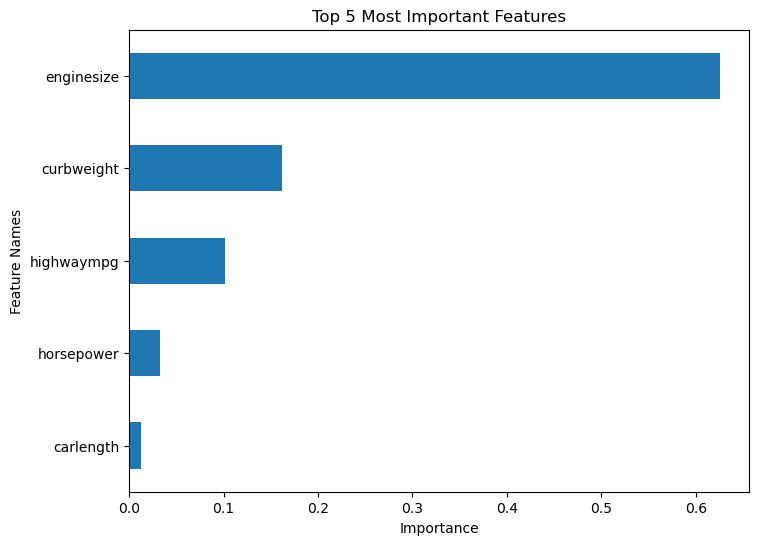

In [20]:
#Get and plot feature importances
importances = get_importances(reg,sort=True,ascending=False,
                              name="RandomForest Importances")
plot_importance(importances,top_n=5);

### Additional EDA

In [21]:
#Create a df for plotting
plot_train = pd.concat([X_train_df,y_train],axis=1)
plot_test = pd.concat([X_test_df,y_test],axis=1)
plot_df = pd.concat([plot_train, plot_test])
plot_df

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,doornumber_four,doornumber_two,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_4wd,drivewheel_fwd,drivewheel_rwd,enginelocation_front,enginelocation_rear,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,price
90,1.0,94.5,165.3,63.8,54.5,2017.0,4.0,103.0,2.99,3.47,21.9,55.0,4800.0,45.0,50.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7099.0
173,-1.0,102.4,175.6,66.5,54.9,2326.0,4.0,122.0,3.31,3.54,8.7,92.0,4200.0,29.0,34.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8948.0
93,1.0,94.5,170.2,63.8,53.5,2024.0,4.0,97.0,3.15,3.29,9.4,69.0,5200.0,31.0,37.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7349.0
5,2.0,99.8,177.3,66.3,53.1,2507.0,5.0,136.0,3.19,3.40,8.5,110.0,5500.0,19.0,25.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,15250.0
167,2.0,98.4,176.2,65.6,52.0,2540.0,4.0,146.0,3.62,3.50,9.3,116.0,4800.0,24.0,30.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8449.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2.0,93.7,157.9,63.6,53.7,2120.0,4.0,108.0,3.62,2.64,8.7,73.0,4400.0,26.0,31.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7053.0
112,0.0,107.9,186.7,68.4,56.7,3252.0,4.0,152.0,3.70,3.52,21.0,95.0,4150.0,28.0,33.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,16900.0
29,3.0,95.9,173.2,66.3,50.2,2811.0,4.0,156.0,3.60,3.90,7.0,145.0,5000.0,19.0,24.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12964.0
19,1.0,94.5,155.9,63.6,52.0,1874.0,4.0,90.0,3.03,3.11,9.6,70.0,5400.0,38.0,43.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6295.0


In [23]:
def plot_numeric_vs_target(df, x, y='price',
                           figsize=(6,4)):
  """Plots a seaborn regplot with Pearson's correlation (r) added
  to the title.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Calculate the correlation
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]

  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws)

  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})", fontweight='bold')

  # Make sure the plot is shown before the print statement
  plt.show()

  return fig, ax

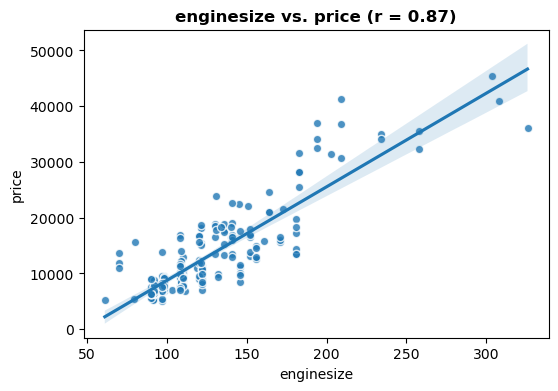

In [24]:
#Plot engine size vs. target
plot_numeric_vs_target(plot_df, x= 'enginesize');

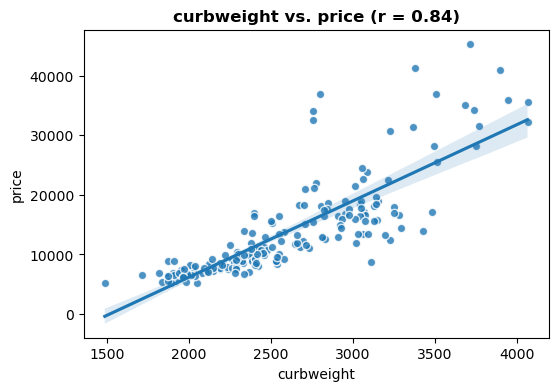

In [25]:
#Plot curb weight vs. target
plot_numeric_vs_target(plot_df, x= 'curbweight');

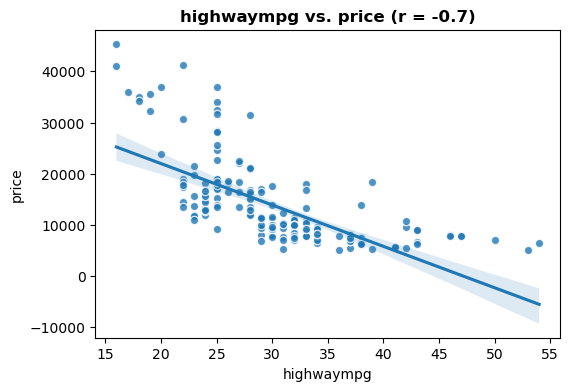

In [26]:
#Plot highway mpg vs. target
plot_numeric_vs_target(plot_df, x= 'highwaympg');

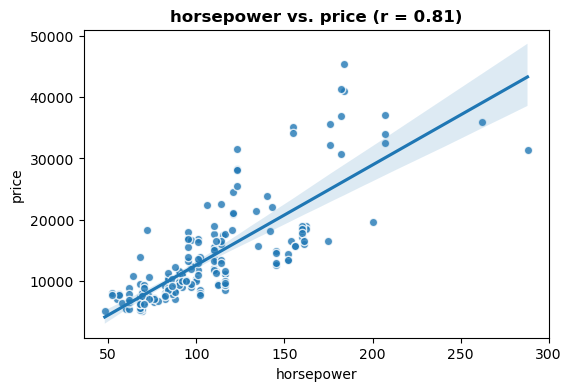

In [27]:
#Plot horsepower vs. target
plot_numeric_vs_target(plot_df, x= 'horsepower');

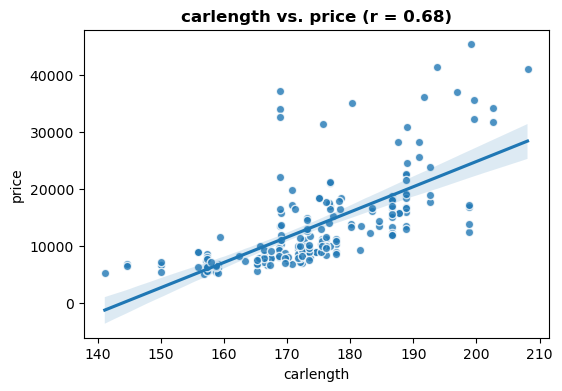

In [28]:
#Plot car length vs. target
plot_numeric_vs_target(plot_df, x= 'carlength');

- We can see that 4 out of the 5 important features show a moderate to strong positive correlation with the target. The only feature that had a negative correlation was highway mpg.

## Permutation Importance

- Answer the Qs:
    - What were your 5 most important features?
        - The top 5 most important features are engine size, curb weight, highway mpg, car width, and horsepower.
    - Are they the same features that your model has as the top 5 important?
        - These are almost the exact same 5, the only difference is car width instead of car length.

In [29]:
from sklearn.inspection import permutation_importance

In [30]:
#Get permutation importances dictionary
r = permutation_importance(reg, X_test_df, y_test,n_repeats =5, random_state = SEED)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [31]:
#Make the mean importances into a series
permutation_importances = pd.Series(r['importances_mean'],index=X_test_df.columns,
                           name = 'permutation importance')
permutation_importances = permutation_importances.sort_values(ascending=False)
permutation_importances

enginesize              0.746913
curbweight              0.081272
highwaympg              0.014019
carwidth                0.005732
horsepower              0.005432
carlength               0.005124
peakrpm                 0.003834
wheelbase               0.002744
stroke                  0.002660
boreratio               0.001944
carheight               0.001742
compressionratio        0.001641
carbody_hatchback       0.001199
carbody_sedan           0.000661
citympg                 0.000640
aspiration_std          0.000354
aspiration_turbo        0.000272
fuelsystem_2bbl         0.000239
fuelsystem_idi          0.000164
fuelsystem_4bbl         0.000126
carbody_wagon           0.000107
drivewheel_4wd          0.000093
enginetype_ohcv         0.000074
enginetype_ohcf         0.000037
fuelsystem_1bbl         0.000003
enginetype_dohc         0.000003
enginetype_dohcv        0.000000
enginelocation_front    0.000000
enginelocation_rear     0.000000
fuelsystem_spfi         0.000000
carbody_co

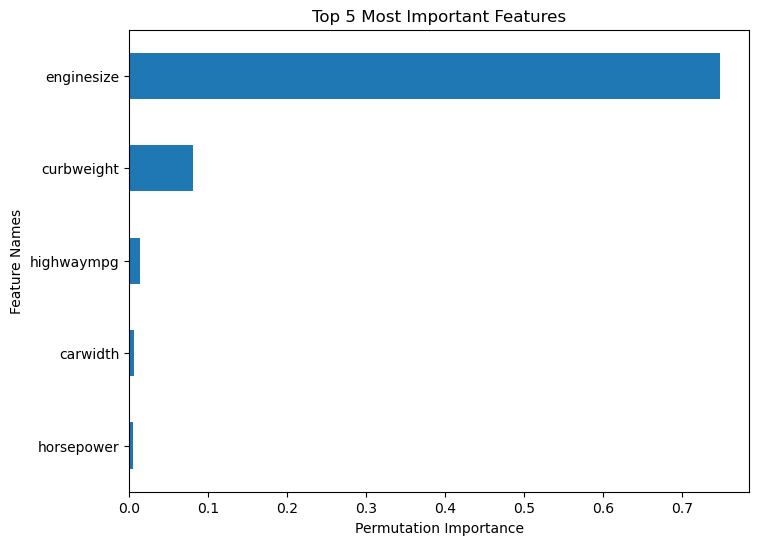

In [33]:
#Plot top 5 permutation importances
ax = plot_importance(permutation_importances,top_n=5)
ax.set(xlabel='Permutation Importance');

### Additional EDA

In [34]:
def plot_importance_color_ax(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None, ax=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize, ax=ax)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

In [36]:
## color -coding top 5 bars
highlight_feats = importances.sort_values(ascending=True).tail(5).index
highlight_feats

Index(['carlength', 'horsepower', 'highwaympg', 'curbweight', 'enginesize'], dtype='object')

In [37]:
## create a dictionary of each feature and its color
colors_dict = {}
for col in importances.index:
    if col in highlight_feats:
        colors_dict[col] = 'green'    
    else:
        colors_dict[col] = '#006ba4'
colors_dict

{'enginesize': 'green',
 'curbweight': 'green',
 'highwaympg': 'green',
 'horsepower': 'green',
 'carlength': 'green',
 'carwidth': '#006ba4',
 'citympg': '#006ba4',
 'cylindernumber': '#006ba4',
 'peakrpm': '#006ba4',
 'boreratio': '#006ba4',
 'stroke': '#006ba4',
 'wheelbase': '#006ba4',
 'compressionratio': '#006ba4',
 'carheight': '#006ba4',
 'enginetype_ohc': '#006ba4',
 'carbody_convertible': '#006ba4',
 'drivewheel_rwd': '#006ba4',
 'carbody_hardtop': '#006ba4',
 'symboling': '#006ba4',
 'aspiration_std': '#006ba4',
 'carbody_sedan': '#006ba4',
 'fuelsystem_mpfi': '#006ba4',
 'aspiration_turbo': '#006ba4',
 'carbody_hatchback': '#006ba4',
 'carbody_wagon': '#006ba4',
 'fuelsystem_2bbl': '#006ba4',
 'drivewheel_fwd': '#006ba4',
 'drivewheel_4wd': '#006ba4',
 'fuelsystem_idi': '#006ba4',
 'doornumber_four': '#006ba4',
 'doornumber_two': '#006ba4',
 'enginetype_dohc': '#006ba4',
 'enginetype_ohcv': '#006ba4',
 'enginetype_l': '#006ba4',
 'enginetype_dohcv': '#006ba4',
 'enginetype_

In [40]:
def get_color_dict(importances, color_rest='#006ba4' , color_top='green',
                    top_n=7):
    ## color -coding top 5 bars
    highlight_feats = importances.sort_values(ascending=True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict

In [41]:
colors_top7 = get_color_dict(importances, top_n=7)
colors_top7

{'enginesize': 'green',
 'curbweight': 'green',
 'highwaympg': 'green',
 'horsepower': 'green',
 'carlength': 'green',
 'carwidth': 'green',
 'citympg': 'green',
 'cylindernumber': '#006ba4',
 'peakrpm': '#006ba4',
 'boreratio': '#006ba4',
 'stroke': '#006ba4',
 'wheelbase': '#006ba4',
 'compressionratio': '#006ba4',
 'carheight': '#006ba4',
 'enginetype_ohc': '#006ba4',
 'carbody_convertible': '#006ba4',
 'drivewheel_rwd': '#006ba4',
 'carbody_hardtop': '#006ba4',
 'symboling': '#006ba4',
 'aspiration_std': '#006ba4',
 'carbody_sedan': '#006ba4',
 'fuelsystem_mpfi': '#006ba4',
 'aspiration_turbo': '#006ba4',
 'carbody_hatchback': '#006ba4',
 'carbody_wagon': '#006ba4',
 'fuelsystem_2bbl': '#006ba4',
 'drivewheel_fwd': '#006ba4',
 'drivewheel_4wd': '#006ba4',
 'fuelsystem_idi': '#006ba4',
 'doornumber_four': '#006ba4',
 'doornumber_two': '#006ba4',
 'enginetype_dohc': '#006ba4',
 'enginetype_ohcv': '#006ba4',
 'enginetype_l': '#006ba4',
 'enginetype_dohcv': '#006ba4',
 'enginetype_roto

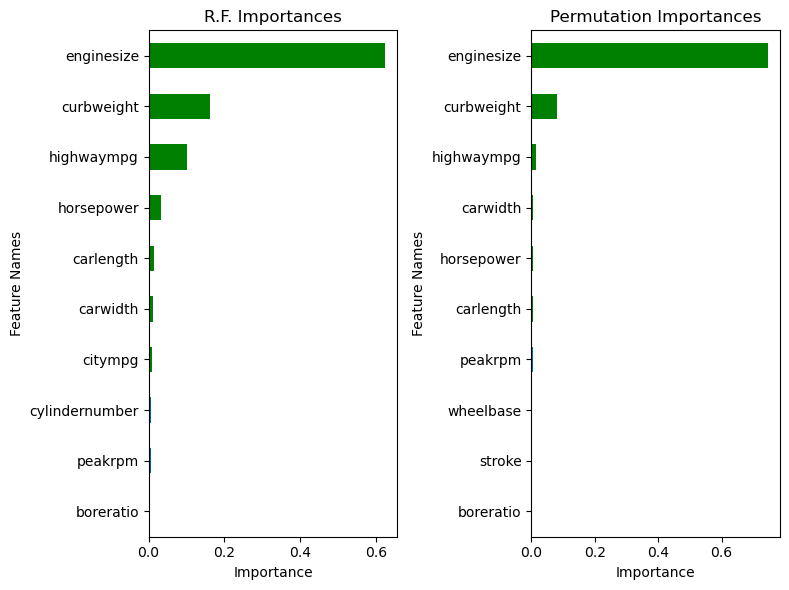

In [43]:
fig, axes = plt.subplots(ncols=2, figsize=(20,8))
n = 10 # setting the # of features to use for both subplots
plot_importance_color_ax(importances, top_n=n, ax=axes[0],
                         color_dict= colors_top7)
plot_importance_color_ax(permutation_importances, top_n=n, ax=axes[1],
                         color_dict=colors_top7)
axes[0].set(title='R.F. Importances')
axes[1].set(title='Permutation Importances')
fig.tight_layout()

- For the model used here, both types of importances came up with relatively the same features that were the most used (important) when making predictions.